In [ ]:
#connect with drive
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

#import packages and functions
!pip install pyspark
!pip3 install catboost
!pip install imbalanced-learn


import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta,date
import functools as ft
import pickle

#Spark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import random
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType, StructType
from pyspark.sql.functions import split
from pyspark.sql.functions import *
from pyspark.sql.functions import window
from pyspark.sql.window import Window

#For modelling
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 199 kB 34.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=593fc3536b2bb1a0ca14e477de1657c2e4df623a8084c20daebf3ece0a94501a
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 135 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_pickle('/content/drive/My Drive/capstone 2 pickle files/df_modeling.pickle')

In [ ]:
df.head()

,visitNumber,totals_timeOnSite,15_day_visit,7_day_visit,totals_hits,totals_pageviews,hits_array_product_array_productPrice,hits_array_product_array_localProductPrice,hits_array_product_array_productListPosition,totals_transactionRevenue,totals_totalTransactionRevenue,hits_array_hitNumber,totals_transactions,churn30,fullVisitorId,date
0,1,32.0,1,1,4,4.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,1817471995140233335,2017-02-20
1,1,915.0,2,2,16,14.0,24990000.0,24990000.0,1.0,0.0,0.0,1,0.0,1,6907085736722365389,2017-02-20
2,1,915.0,2,2,16,14.0,24990000.0,24990000.0,1.0,0.0,0.0,1,0.0,1,6907085736722365389,2017-02-20
3,3,1116.0,3,3,29,25.0,24990000.0,24990000.0,1.0,0.0,0.0,1,0.0,1,6210993043771295443,2017-02-20
4,3,1116.0,3,3,29,25.0,24990000.0,24990000.0,1.0,0.0,0.0,1,0.0,1,6210993043771295443,2017-02-20


In [ ]:
X = df.drop(['churn30','fullVisitorId','date'], axis = 1)
y = df.churn30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

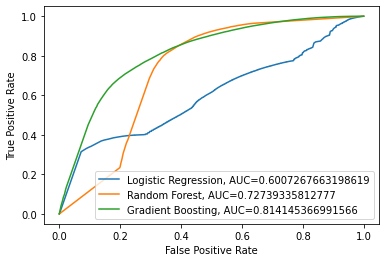

In [ ]:
#set up plotting area
plt.figure(0).clf()

#fit logistic regression model and plot ROC curve
steps = [('over', RandomOverSampler()), ('model', LogisticRegression())]
model = Pipeline(steps=steps)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#fit random forest model and plot ROC curve
steps = [('over', RandomOverSampler()), ('model', DecisionTreeClassifier())]
model = Pipeline(steps=steps)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
steps = [('over', RandomOverSampler()), ('model', GradientBoostingClassifier())]
model = Pipeline(steps = steps)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

#add legend
plt.legend()

#axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

GBM has the highest AUC score (0.81). We will use this model going forward

In [ ]:
#Tuning hyperparameters 
steps = [('over', RandomOverSampler()), ('model', GradientBoostingClassifier())]
model = Pipeline(steps = steps)

learning_rate_list = np.linspace(0.001, 2, 150)
max_depth_list = range(3,11)
subsample_list = np.linspace(0.7, 1, 10)
min_weight_fraction_leaf_list = np.linspace(0.1, 0.5, 40)
n_estimators_list = range(5, 20)

params = {'model__learning_rate':learning_rate_list, 'model__max_depth':max_depth_list,'model__subsample':subsample_list,\
          'model__min_weight_fraction_leaf':min_weight_fraction_leaf_list,\
          'model__n_estimators':n_estimators_list}

number_models = 10
random_GBM_class = RandomizedSearchCV(\
                                      estimator = model,\
                                      param_distributions = params,\
                                      n_iter = number_models,\
                                      scoring = 'roc_auc',\
                                      n_jobs = 4,\
                                      cv = 10,\
                                      refit = True,\
                                      return_train_score = True)

gs = random_GBM_class.fit(X_train, y_train)

In [ ]:
gs.best_params_

{'model__subsample': 1.0,
 'model__n_estimators': 18,
 'model__min_weight_fraction_leaf': 0.13076923076923078,
 'model__max_depth': 10,
 'model__learning_rate': 1.1413691275167785}

In [ ]:
GBM = GradientBoostingClassifier(learning_rate=0.5778926174496645, subsample=0.9333333333333333, n_estimators=16, min_weight_fraction_leaf=0.12051282051282051, max_depth=9,random_state=10)
steps = [('over', RandomOverSampler()),('model', GBM)]
model = Pipeline(steps = steps)
model.fit(X_train, y_train)
predict_prob_test = model.predict_proba(X_test)[:, 1]

In [ ]:
def adr_table(predictions, target, quantiles, top_pct=True, acscend=False):
    """
    :param predictions: 
    :param target: 
    :return: table with ADR at top
    """
    
    #What is the purpose of top_pct = True or False?
    df_=pd.DataFrame({'predict':predictions.ravel(),'target':target})
    q=df_['predict'].quantile(quantiles[::-1])
    c=np.unique(q)
    df_['top_pct'] = pd.cut(df_['predict'],c,include_lowest=True,labels=range(1,len(c)))
    gains = df_.groupby('top_pct')['target'].agg(['count','sum'])
    gains.sort_values(by=['top_pct'],inplace=True,ascending=acscend)
    gains.columns = ['count','bads']
    gains['goods'] = gains['count'] - gains['bads']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_bads'] = gains['bads'].cumsum()
    gains['cum_goods'] = gains['goods'].cumsum()
    gains['percent_cum_bads'] = (gains['cum_bads'] / np.max(gains['cum_bads'])).round(2)
    gains['percent_cum_goods'] = (gains['cum_goods'] / np.max(gains['cum_goods'])).round(2)
    gains['if_random'] = np.max(gains['cum_bads']) /gains.shape[0]
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_bads'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_bads'] - gains['percent_cum_goods'] ) * 100
    gains['gain']=(gains['cum_bads']/gains['cum_count']*100).round(2)
    if top_pct:
        tmp_top_pcts = q.drop_duplicates(keep = 'first').index[:-1]
        tmp_label = np.arange(1,len(tmp_top_pcts)+1)
        col_dict = {A: B for A, B in zip(tmp_label, tmp_top_pcts)}
        gains_model = pd.DataFrame(gains).reset_index()
        gains_model['top_pct'].replace(col_dict, inplace=True)
        gains_model['threshold'] = q.drop_duplicates(keep = 'first').values[:-1]
    else:
        gains_model = pd.DataFrame(gains).reset_index()
    return gains_model

deciles = np.linspace(0,1,11,0.1)
gain_df = adr_table(predict_prob_test,y_test,deciles)



Assuming life-time value of a customer is 100 dollars if he or she does not churn and we will be spending 10 dollars per customer in our retention marketing campaign. Not churned customers tend to be more engaged and have higher chance of adopting our promo. We will test 3 scenarios: <br>1) 10% promo adoption rate among both "not churned" and "churned" groups <br> 2) 10% adoption rate among the churned, 20% among the not churned group <br>3) 10% adoption rate among the churned group and 40% among the not churned group. <br>We also assume that 20% of the high churn propensity who adopt our promo will end up not churning 

In [ ]:
gain_df['scenario_1_cost'] = gain_df['cum_count']*0.1*10
gain_df['scenario_1_profit'] = gain_df['cum_bads']*0.1*0.2*100 - gain_df['scenario_1_cost']
gain_df['scenario_2_cost'] = (gain_df['cum_bads']*0.1 + gain_df['cum_goods']*0.2)*10
gain_df['scenario_2_profit'] = gain_df['cum_bads']*0.1*0.2*100 - gain_df['scenario_2_cost']
gain_df['scenario_3_cost'] = (gain_df['cum_bads']*0.1 + gain_df['cum_goods']*0.4)*10
gain_df['scenario_3_profit'] = gain_df['cum_bads']*0.1*0.2*100 - gain_df['scenario_3_cost']

In [ ]:
gain_df

,top_pct,count,bads,goods,cum_count,cum_bads,cum_goods,percent_cum_bads,percent_cum_goods,if_random,lift,K_S,gain,threshold,scenario_1_cost,scenario_1_profit,scenario_2_cost,scenario_2_profit,scenario_3_cost,scenario_3_profit
0,0.1,21741,20982,759,21741,20982,759,0.10,0.02,23651.888889,0.89,8.0,96.51,0.853420,21741.0,20223.0,22500.0,19464.0,24018.0,17946.0
1,0.2,5241,4975,266,26982,25957,1025,0.12,0.02,47303.777778,0.55,10.0,96.20,0.810491,26982.0,24932.0,28007.0,23907.0,30057.0,21857.0
2,0.3,75938,72512,3426,102920,98469,4451,0.46,0.10,70955.666667,1.39,36.0,95.68,0.804561,102920.0,94018.0,107371.0,89567.0,116273.0,80665.0
3,0.4,25801,24167,1634,128721,122636,6085,0.58,0.14,94607.555556,1.30,44.0,95.27,0.780855,128721.0,116551.0,134806.0,110466.0,146976.0,98296.0
4,0.5,24799,21995,2804,153520,144631,8889,0.68,0.20,118259.444444,1.22,48.0,94.21,0.713140,153520.0,135742.0,162409.0,126853.0,180187.0,109075.0
5,0.6,23601,19372,4229,177121,164003,13118,0.77,0.29,141911.333333,1.16,48.0,92.59,0.583939,177121.0,150885.0,190239.0,137767.0,216475.0,111531.0
6,0.8,29073,22280,6793,206194,186283,19911,0.88,0.44,165563.222222,1.13,44.0,90.34,0.457511,206194.0,166372.0,226105.0,146461.0,265927.0,106639.0
7,0.9,25425,16393,9032,231619,202676,28943,0.95,0.64,189215.111111,1.07,31.0,87.50,0.344033,231619.0,173733.0,260562.0,144790.0,318448.0,86904.0
8,1.0,26143,10191,15952,257762,212867,44895,1.00,1.00,212867.000000,1.00,0.0,82.58,0.216119,257762.0,167972.0,302657.0,123077.0,392447.0,33287.0



Scenario 2 and 3 are more realistic: Not churned customers are those inherently interested in our products and more receptive to our marketing effort, hence we can expect them to be more likely to use the promo. 

The profit peaks at 80th percentile for scenario 2 and 60% for scenario 3.

Marketing team may have budget constrainst and depending on the projected promo redemption rate, we can decide how many people to target in the campaign.   

Assuming we are leaning toward scenario 3 and the marketing budget is $200k, we'll then decide to target the 40th percentile of population (153k people with highest probability to churn)